In [34]:
!pip install numpy pandas matplotlib seaborn iminuit


[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: pip install --upgrade pip


In [35]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from iminuit import Minuit

In [73]:
detA = pd.read_csv("../data/DetectorA.csv", header=None, names=["event_id", "class_score", "energy"])

detB = pd.read_csv("../data/DetectorB.csv", header=None, names=["event_id", "class_score", "energy"])

Text(0, 0.5, 'Frequency')

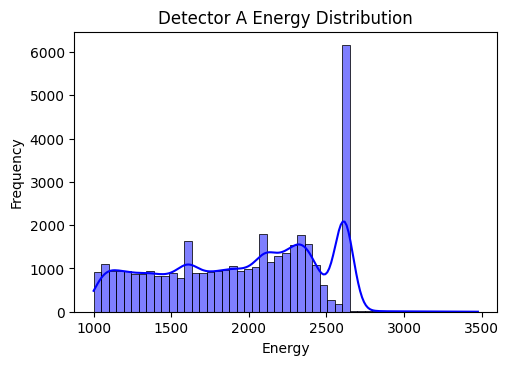

In [5]:
plt.figure(figsize=(12, 8))
plt.subplot(2, 2, 1)
sns.histplot(detA['energy'], kde=True, color='blue')
plt.title('Detector A Energy Distribution')
plt.xlabel('Energy')
plt.ylabel('Frequency')

Text(0, 0.5, 'Class Score')

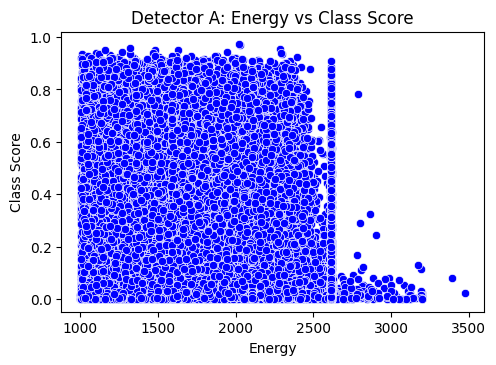

In [6]:

plt.figure(figsize=(12, 8))
plt.subplot(2, 2, 1)
sns.scatterplot(x='energy', y='class_score', data=detA, color='blue')
plt.title('Detector A: Energy vs Class Score')
plt.xlabel('Energy')
plt.ylabel('Class Score')

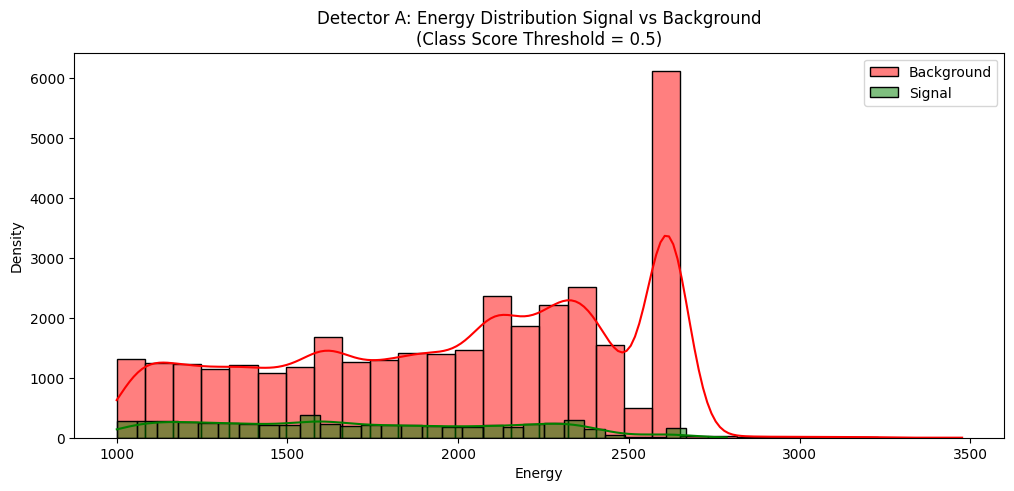

In [7]:
def split_plot(data, name, thresh=0.5, bins=30):
    detSignal = data[data['class_score'] > thresh]
    detBackground = data[data['class_score'] <= thresh]
    plt.figure(figsize=(12, 5))
    sns.histplot(detBackground['energy'], color='red', label='Background', kde=True, bins=bins)
    sns.histplot(detSignal['energy'], color='green', label='Signal', kde=True, bins=bins)
    plt.title(f'{name}: Energy Distribution Signal vs Background\n(Class Score Threshold = {thresh})')
    plt.xlabel('Energy')
    plt.ylabel('Density')
    plt.legend()
    plt.show()

split_plot(detA, 'Detector A', 0.5)

# 2a. Use 1592 keV peak in Detector A to set a cutting threshold


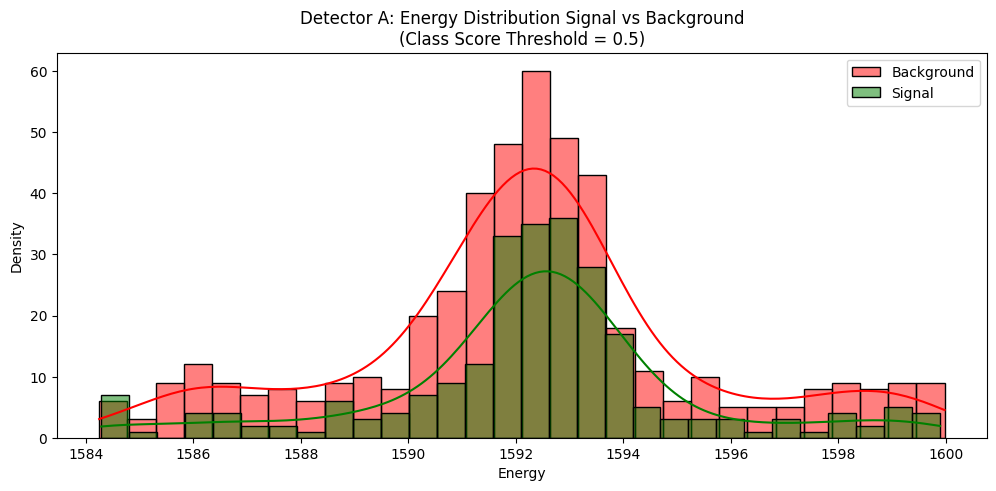

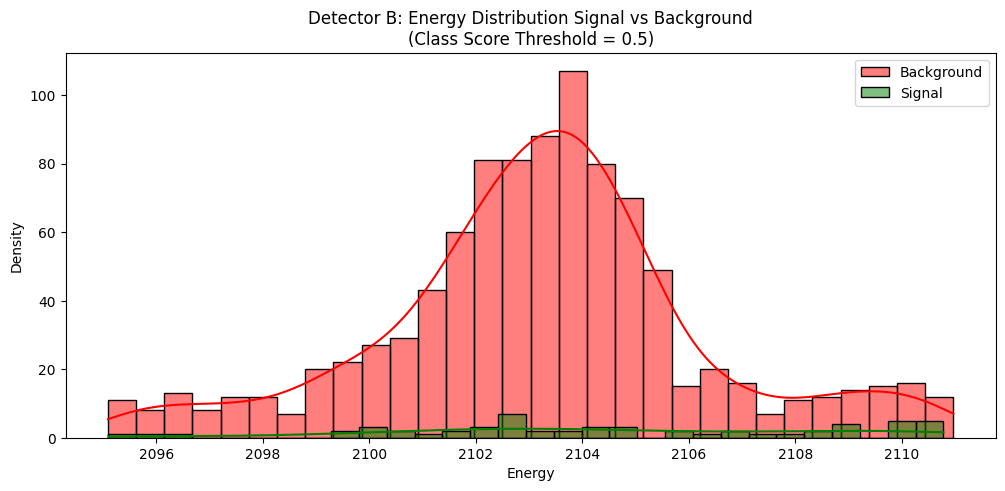

In [75]:
aReg = detA[(detA['energy'] > 1584) & (detA['energy'] < 1600)]
bReg = detB[(detB['energy'] > 2095) & (detB['energy'] < 2111)]

split_plot(aReg, 'Detector A', 0.5)
split_plot(bReg, 'Detector B', 0.5)

Best Threshold: 0.0900, TPR: 0.7775, FPR: 0.2886


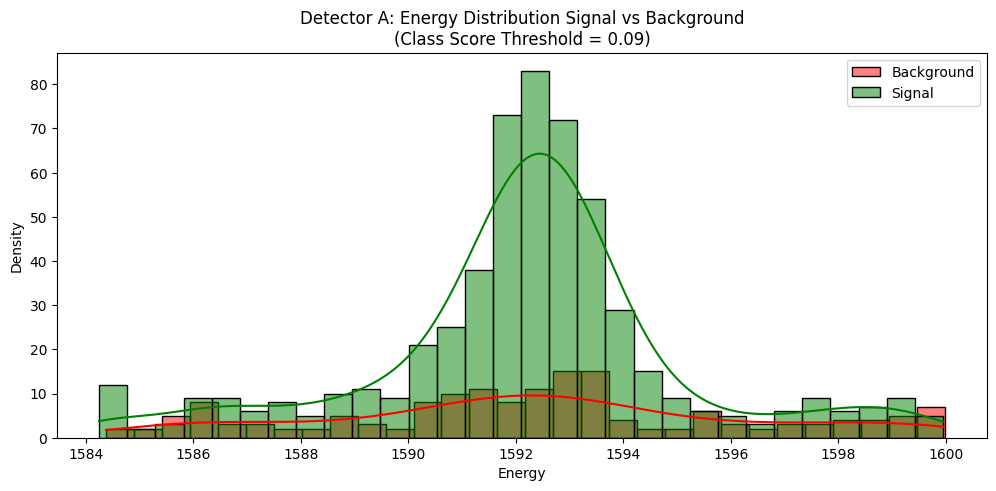

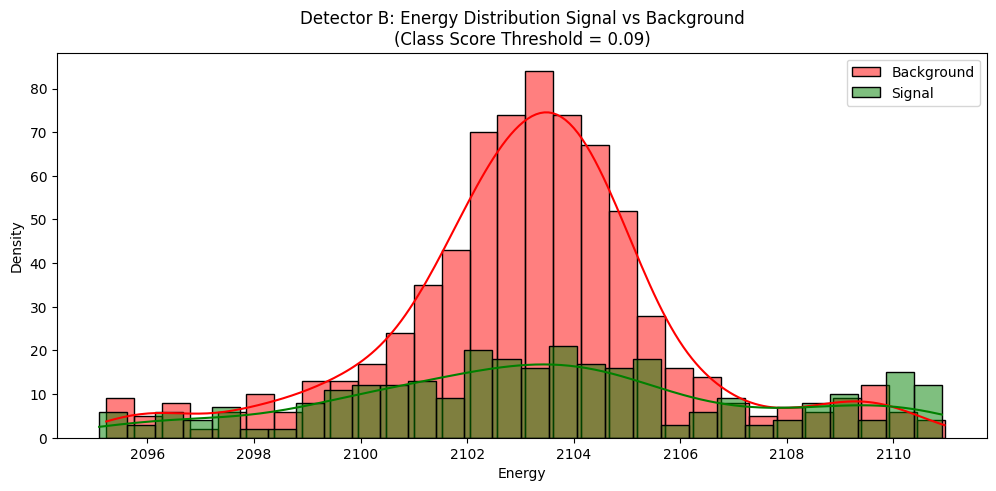

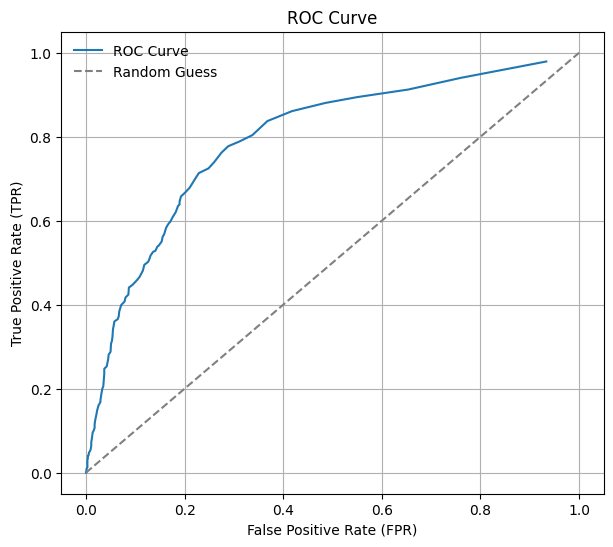

In [ ]:
fpr = []
tpr = []
best_TPR = 0
best_FPR = 1
threshold = 0

while threshold <= 1:
    # sigA is mostly true positives
    # sigB is mostly true negatives
    sigA = aReg[aReg['class_score'] > threshold]
    bkgA = aReg[aReg['class_score'] <= threshold]
    sigB = bReg[bReg['class_score'] > threshold]
    bkgB = bReg[bReg['class_score'] <= threshold]
    #Calc TPR, FPR and collect for ROC curve
    TPR = len(sigA) / (len(sigA) + len(bkgA))
    FPR = len(sigB) / (len(sigB) + len(bkgB))
    fpr.append(FPR)
    tpr.append(TPR)
    #Capture best values
    if TPR - FPR > best_TPR - best_FPR:
        best_TPR = TPR
        best_FPR = FPR
        best_threshold = threshold
    threshold += 0.01

print(f"Best Threshold: {best_threshold:.4f}, TPR: {best_TPR:.4f}, FPR: {best_FPR:.4f}")
split_plot(aReg, 'Detector A', best_threshold)
split_plot(bReg, 'Detector B', best_threshold)

# Plot ROC curve
plt.figure(figsize=(7, 6))
plt.plot(fpr, tpr, linestyle='-', label="ROC Curve")
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label="Random Guess")
plt.xlabel("False Positive Rate (FPR)")
plt.ylabel("True Positive Rate (TPR)")
plt.title("ROC Curve")
plt.legend(frameon=False)
plt.grid()
plt.show()
    



# 2b. Subtract baseline using linear + Gaussian model

In [69]:
def fit_signal_background(data, E_min, E_max, n_bins=30):
    reg_select = detA[(detA['energy'] > E_min) & (detA['energy'] < E_max)]
    intervals, bins = pd.cut(reg_select['energy'], bins=n_bins, retbins=True)
    x_data = (bins[1:] + bins[:-1]) / 2
    bin_width = bins[1] - bins[0]
    y_data = intervals.value_counts().sort_index().values

    def fit_func(x_data, A, mu, sigma, a, b):
        bkg = a * x_data + b
        gauss_model = A * np.exp(-0.5 * ((x_data - mu) / sigma) ** 2)
        return bkg + gauss_model

    def chi2(A, mu, sigma, a, b):
        y_model = fit_func(x_data, A, mu, sigma, a, b)
        quad_diffs = (y_data - y_model) ** 2
        return np.sum(quad_diffs / y_data)
    
    m = Minuit(chi2, A=np.max(y_data)/2, mu=1592, sigma=2, a=0, b=5)
    m.limits['mu'] = (1500, 1594)
    m.limits['sigma'] = (0, None)
    m.migrad()
    print(m.values)
    A_fit, mu_fit, sigma_fit, a_fit, b_fit = m.values['A','mu','sigma','a','b']
    bkgfit_y = a_fit * x_data + b_fit
    modelfit_y = A_fit * np.exp(-0.5 * ((x_data - mu_fit) / sigma_fit) ** 2)
    total_model_y = bkgfit_y + modelfit_y

    # Plot signal, backgound, and measured
    plt.plot(x_data, total_model_y, label = 'Total model')
    plt.plot(x_data, modelfit_y,'-.', label = 'Signal Model')
    plt.plot(x_data, bkgfit_y, label = 'Background Model')
    plt.scatter(x_data, y_data, color='black', label = 'Measured Histogram')
    plt.xlabel('Invariant Mass (GeV)')
    plt.ylabel('Counts per bin')
    plt.title('Invariant Mass Fit')
    plt.legend()
    plt.show()
    
    return x_data, bin_width, y_data - bkgfit_y



<ValueView A=86.12218910758635 mu=1592.3946801959985 sigma=0.9976747957728683 a=0.0610685672304069 b=-87.9094866685632>


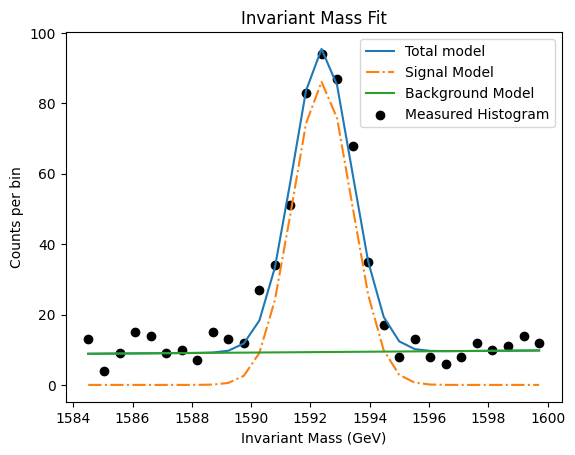

In [70]:
bin_centers, bin_width, rmvd_bkg = fit_signal_background(detA, 1584, 1600, n_bins=30)

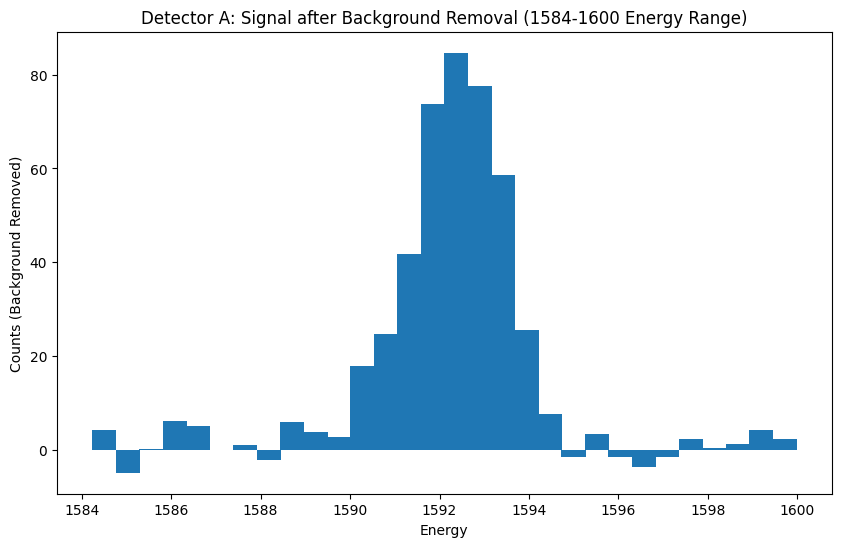

In [71]:
plt.figure(figsize=(10,6))
plt.bar(bin_centers, rmvd_bkg, width=bin_width)
plt.xlabel('Energy')
plt.ylabel('Counts (Background Removed)')
plt.title('Detector A: Signal after Background Removal (1584-1600 Energy Range)')
plt.show()